# Reinforcement Learning

The goal of RL is to learn an optimal policy $\pi^\ast$ for an *agent* operating in some environment $E$.

<div>
<img src="attachment:image.png" width="300" />
</div>

See: https://en.wikipedia.org/wiki/Reinforcement_learning

## Markov Decision Process (MDP)

A suitable mathematical framework to study RL are the Marko Decision Processes (MDPs)

#### MDP example: OpenAI Gym Frozen lake environment

<div>
<img src="attachment:image.png" widht="300" />
</div>

See: https://gymnasium.farama.org/environments/toy_text/frozen_lake/

Let's important necessary packages. Note that you need to install the OpenAI Gym environment.

In [1]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt

Now we can create the environment. You should test both the slippery and non-slippery lakes.

In [2]:
# Create environment
env = gym.make("FrozenLake-v1", is_slippery=True)
env.reset()
env.render()

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't 

error: ignored

In [3]:
action_size = env.action_space.n
print("Action size: ", action_size)

state_size = env.observation_space.n
print("State size: ", state_size)

Action size:  4
State size:  16


In [4]:
done = False
env.reset()
env.render()
while not done:
    #action = np.random.randint(0,4) # 0:Left 1:Down 2: Right, 3: Up
    action = int(input('0/left 1/down 2/right 3/up:'))
    new_state, reward, done, info = env.step(action)
    time.sleep(1.0) 
    print(f'S_t+1={new_state}, r_t+1={reward}, done={done}')
    env.render()

error: ignored

Let's define a fixed policy that follows one successful route.

In [5]:
pi = np.zeros((16)).astype(int)
pi[0] = 2
pi[1] = 2
pi[2] = 1
pi[6] = 1
pi[10] = 1
pi[14] = 2
print(pi)

[2 2 1 0 0 0 1 0 0 0 1 0 0 0 2 0]


Let's define a function that evaluates the given policy

In [6]:
def eval_policy(env_, pi_, gamma_):
    env_.reset()

    s_t = env.reset()
    v_pi = 0
    for t in range(666):
        a_t = pi_[s_t]
        s_t, r_t, done, info = env_.step(a_t) 
        v_pi += gamma_**t*r_t
        if done:
            break
    env.close()
    return v_pi

Test the policy evaluation several times. Test separately for slipper and non-slippery cases.

In [7]:
val = eval_policy(env,pi,0.9)
print(val)

0.0


For the non-deterministic case (slippery ice) we need to repeat the evaluation and calculate mean, min and max.

In [8]:
def eval_policy_better(env_, pi_, gamma_, t_max_, episodes_):
    env_.reset()

    v_pi_rep = np.empty(episodes_)
    for e in range(episodes_):
        s_t = env.reset()
        v_pi = 0
        for t in range(t_max_):
            a_t = pi_[s_t]
            s_t, r_t, done, info = env_.step(a_t) 
            v_pi += gamma_**t*r_t
            if done:
                break
        v_pi_rep[e] = v_pi
        env.close()
    return np.mean(v_pi_rep), np.min(v_pi_rep), np.max(v_pi_rep), np.std(v_pi_rep)

Now you may test how many episodes are needed so that the mean, min and max estimates are stable.

In [9]:
val_mean, val_min, val_max, val_std = eval_policy_better(env,pi,0.9, 666, 1000)
print(f'Value function mean {val_mean:.4f}, min {val_min:.4f} max {val_max:.4f}')

Value function mean 0.0035, min 0.0000 max 0.5905


## Q-learning

<div>
<img src="attachment:image-2.png" width="500" />
</div>

From the RL bible:

 * R.S. Sutton and A.G. Barto (2021): Reinforcement Learning: An Introduction. 2n ed. [PDF](http://incompleteideas.net/book/the-book.html) 

#### Q-learning example: Frozen lake

Play with the Q-learning parameter to understand their meaning

In [ ]:
qtable = np.zeros((16,4)) # Frozen lake
episodes = 1000 # num of training episodes
interactions = 100 # max num of interactions per episode
epsilon = 0.99 # e-greedy
alpha = 0.5 # learning rate - 1.
gamma = 0.9 # reward decay rate
debug = 0 # for non-slippery case to observe learning
hist = [] # evaluation history

# Main Q-learning loop
for episode in range(episodes):

    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for interact in range(interactions):
        # exploitation vs. exploratin by e-greedy sampling of actions
        if np.random.uniform(0, 1) > epsilon:
            action = np.argmax(qtable[state,:])
        else:
            action = np.random.randint(0,4)

        # Observe
        new_state, reward, done, info = env.step(action)

        # Update Q-table
        qtable[state, action] = qtable[state, action] + alpha * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
                
        # Our new state is state
        state = new_state
        
        # Check if terminated
        if done == True: 
            break
    
    if episode % 10 == 0 or episode == 1:
        pi = np.argmax(qtable, axis=1)
        val_mean, val_min, val_max, val_std = eval_policy_better(env, pi, gamma, interactions, 1000)
        hist.append([episode, val_mean,val_min,val_max,val_std])
        if debug == True:
            print(pi)
            print(val_mean)

env.reset()

0

Plot average performance. Does that tell the whole truth for the slipper and non-slippery case? 

(101, 5)


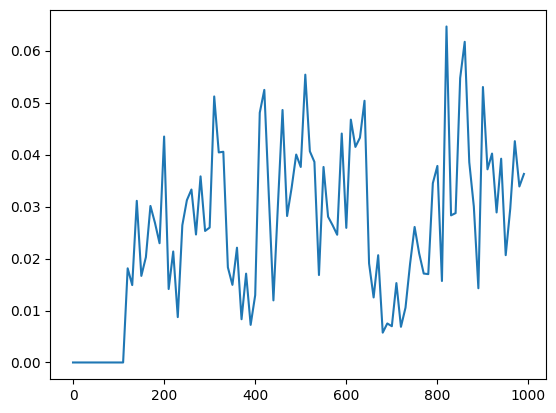

In [ ]:
hist = np.array(hist)
print(hist.shape)

plt.plot(hist[:,0],hist[:,1])
plt.show()

Let's add +-1-standard deviation to the plot

(101, 5)


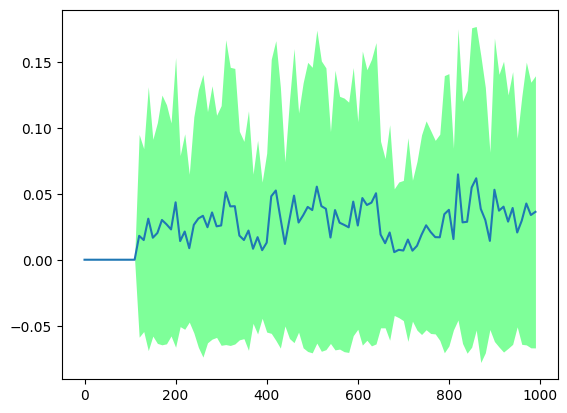

In [ ]:
hist = np.array(hist)
print(hist.shape)

plt.plot(hist[:,0],hist[:,1])
# Zero-clipped
#plt.fill_between(hist[:,0], np.maximum(hist[:,1]-hist[:,4],np.zeros(hist.shape[0])),hist[:,1]+hist[:,4],
plt.fill_between(hist[:,0], hist[:,1]-hist[:,4],hist[:,1]+hist[:,4],
    alpha=1, edgecolor='#3F7F4C', facecolor='#7EFF99',
    linewidth=0)
plt.show()

Let's define an evaluation function that runs the current policy (action that maximises Q-value in each state) and return average reward

Let's test the initial Q-table full of zeros. Note that you need to define number of episodes and max number of steps so that vaues stabilize over random runs.

In [ ]:
print(eval_policy(qtable,1000,100))

AttributeError: 'numpy.ndarray' object has no attribute 'reset'

## References

 * R.S. Sutton and A.G. Barto (2021): Reinforcement Learning: An Introduction. 2n ed. URL: http://incompleteideas.net/book/the-book.html 

 * Christopher Wong: "FrozenLake" Blog post. URL: https://cwong8.github.io/projects/FrozenLake/